In [1]:
from google.colab import drive
from os import chdir
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
chdir('/content/drive/MyDrive/Notebooks/Time-Series/Kaggle_Times_Series_Competition')

In [3]:
! pip install wordcloud  &> /dev/null 
! pip install googletrans==4.0.0rc1 &> /dev/null 
! pip install nb_black &> /dev/null   
! pip install lifelines &> /dev/null

In [4]:
import pandas as pd
import numpy as np

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from wordcloud import WordCloud,  STOPWORDS
from sklearn.model_selection import TimeSeriesSplit

from googletrans import Translator

def month_diff(a, b):
    return 12 * (b.year - a.year) + (b.month - a.month)

%load_ext lab_black

# Specialized Models: Time Series and Survival Analysis Final Project
One of the main objectives of this course is to help you gain hands-on experience in communicating insightful and impactful findings to stakeholders. In this project you will leverage the tools and techniques you learned throughout this course, including Time Series Analysis, Survival Analysis, or Deep Learning in an analytical task of your choosing. You can use any of these analysis in any data set that includes a time component. You are free to choose the technique that best help analyze a data set that you feel passionate about. Just as important as the analytical work, you will also prepare a report that communicates insights you found from your model development exercise.

As a main deliverable, you will submit a report that helps you focus on highlighting your analytical skills, thought process, and next steps.

# Description ✒️

---
You are provided with daily historical sales data.
---

## **Goals**
- Find the best selling categories.
- Analyze if there is a life time for the products of each category. 
- Create a model for 2 of the top fieve categories


# **📚Data Description**
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.
# **File descriptions**
* **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
* **item_categories.csv**  - supplemental information about the items categories.

# **Data Field**
* **ID** - an Id that represents a (Shop, Item) tuple within the test set
* **shop_id** - unique identifier of a shop
* **item_id** - unique identifier of a product
* **item_category_id** - unique identifier of item category
* **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
* **item_price** - current price of an item.
* **date** - date in format dd/mm/yyyy
* **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* **item_name** - name of item
* **shop_name** - name of shop
* **item_category_name** - name of item category


# Step
1. Convert the sales_train.csv from daily sales to monthly by product.
2. item_categories.csv have the categories name in russian with need to translate those values.
3. Join both dataset.
4. Converts tha current dataframe into monthly sales by categories.
    



# Exploratory Analysis

In [5]:
plt.rcParams["figure.figsize"] = (12, 10)
plt.style.use('ggplot')

## Product Categories

In [6]:
df_item_categories = pd.read_csv("input/item_categories.csv")
df_item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


The item category name is in Russian we going to use google translator to translate into english.

In [7]:
translator = Translator()
df_item_categories['category_name_eng']= df_item_categories.item_category_name.apply(
                                                                                    lambda 
                                                                                        text: translator.translate(text, src='ru',dest='en').text
                                                                                     )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


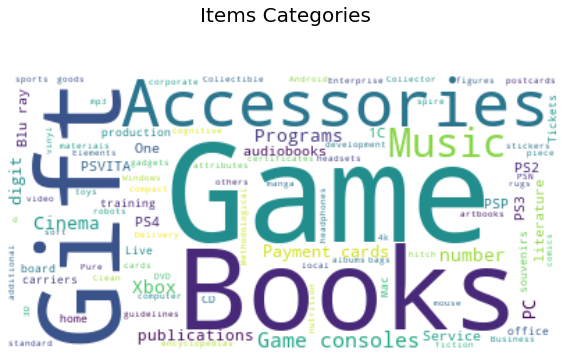

In [8]:
plt.figure(figsize=(8,6))
plt.imshow(
     WordCloud(stopwords = STOPWORDS, background_color="white")\
     .generate(" ".join(df_item_categories.category_name_eng.str.replace("\W+"," ").tolist()))
, interpolation='bilinear',  
 )
plt.axis("off")
plt.suptitle('Items Categories',size=20)
plt.tight_layout(pad=1)
plt.show()

We can observed that we have similar categories, we going to group for example every game consoles in a single one and also Games that are related to consoles into video games.

In [9]:
df_item_categories.category_name_eng.unique()

array(['PC - headsets/headphones', 'Accessories - PS2',
       'Accessories - PS3', 'Accessories - PS4', 'Accessories - PSP',
       'Accessories - PSVITA', 'Accessories - Xbox 360',
       'Accessories - Xbox One', 'Tickets (number)', 'Delivery of goods',
       'Game consoles - PS2', 'Game consoles - PS3',
       'Game consoles - PS4', 'Game consoles - PSP',
       'Game consoles - PSVITA', 'Game consoles - Xbox 360',
       'Game consoles - Xbox One', 'Game consoles - others',
       'Games - PS2', 'Games - PS3', 'Games - PS4', 'Games - PSP',
       'Games - PSVITA', 'Games - Xbox 360', 'Games - Xbox One',
       'Games - accessories for games', 'Android games - number',
       'Mac games - digit', 'PC games - additional publications',
       'PC Games - Collectible Publications',
       'PC games - standard publications', 'PC games - digit',
       'Payment cards (cinema, music, games)', 'Payment cards - Live!',
       'Payment cards - Live!(Number)', 'Payment cards - PSN',
       

In [10]:
split_item_name = df_item_categories.category_name_eng.str.split('-')
df_item_categories["product_type"] = split_item_name.apply(lambda x: x[0].strip())
df_item_categories["product_sub_type"] = split_item_name.apply(lambda x: x[1] if len(x)>1 else None)
df_item_categories.loc[lambda x: (~x.category_name_eng.str.upper().str.contains( "CONSOLE|PAYMENT|BOARD|ACCESSORIES" ))
            &(x.category_name_eng.str.upper().str.contains( "PC|PS\d|XBOX|PSP|ANDROID|PSVITA|MAC" ) )
            & (x.category_name_eng.str.upper().str.contains( "GAMES*" ) ) ,"product_type"] = 'Video Games'
df_item_categories.loc[lambda x: (~x.category_name_eng.str.upper().str.contains( "CONSOLE" ))
            &(x.category_name_eng.str.upper().str.contains( "PC|PS\d|XBOX|PSP|PSVITA" ) ) 
            &(x.category_name_eng.str.upper().str.contains( "ACCESSORIES" ) ),"product_type"] = 'Accessories consoles'
df_item_categories.loc[lambda x: x.category_name_eng.str.upper().str.contains( "BOOK" ),"product_type"] = 'Books'
df_item_categories.loc[lambda x: x.category_name_eng.str.upper().str.contains( "GIFTS - CARDS|PAYMENT\s*CARDS" ),"product_type"] = "Gifts cards"

In [11]:
df_item = pd.read_csv(
    "input/items.csv",)\
            .merge(df_item_categories
                                    ,on='item_category_id'
                                       ,how='inner'
                                           ,validate='m:1'
                      )
df_item.head()

,item_name,item_id,item_category_id,item_category_name,category_name_eng,product_type,product_sub_type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Cinema - DVD,Cinema,DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Cinema - DVD,Cinema,DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Cinema - DVD,Cinema,DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Cinema - DVD,Cinema,DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Cinema - DVD,Cinema,DVD


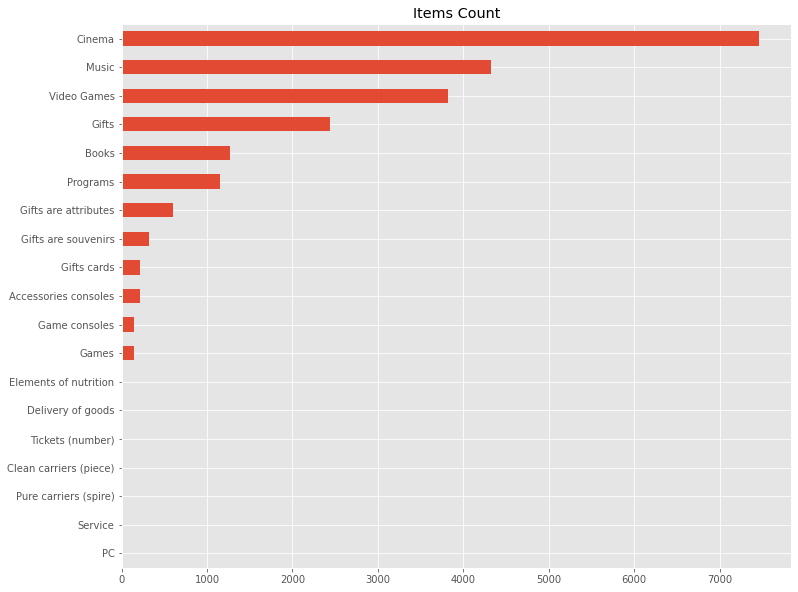

In [12]:
df_item.product_type.value_counts().sort_values().plot.barh(title='Items Count')
plt.show()

#Product Sales

In [13]:
df_sales = pd.read_csv("input/sales_train.csv",
                       parse_dates=['date'],
                       dayfirst=True,
                       infer_datetime_format=True,
                       index_col='date')
df_sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-02,0,59,22154,999.00,1.0
2013-01-03,0,25,2552,899.00,1.0
2013-01-05,0,25,2552,899.00,-1.0
2013-01-06,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


In [14]:
first_date, last_date = df_sales.index.min(), df_sales.index.max()
total_months = month_diff(first_date,last_date)
print(f'first date: {first_date}\nlast date: {last_date}\nmonths: {total_months}')

first date: 2013-01-01 00:00:00
last date: 2015-10-31 00:00:00
months: 33


In [15]:
df_sales['sale'] = df_sales.item_cnt_day.mul(df_sales.item_price) 

In [16]:
df_sales.sale.describe()

count    2.935849e+06
mean     1.157732e+03
std      5.683604e+03
min     -6.897000e+04
25%      2.490000e+02
50%      4.490000e+02
75%      1.078200e+03
max      1.829990e+06
Name: sale, dtype: float64

Here we observed that we have negatives values, so this mean that we have some returns of products, we going to remove this from our analysis

In [17]:
df_monthly_sales = df_sales.query('sale>0')\
.groupby('item_id')\
.resample('M')\
.agg({'item_cnt_day':'sum','sale':'sum'})\
.reset_index()\
.merge(df_item,on='item_id')\
.sort_values(['item_id','date'], ascending = False )

df_monthly_sales.head()

,item_id,date,item_cnt_day,sale,item_name,item_category_id,item_category_name,category_name_eng,product_type,product_sub_type
306206,22169,2014-03-31,1.0,4349.0,Яйцо дракона (Игра престолов),69,Подарки - Сувениры,Gifts are souvenirs,Gifts are souvenirs,None
306205,22168,2013-09-30,1.0,799.0,Яйцо для Little Inu,62,"Подарки - Гаджеты, роботы, спорт","Gifts - gadgets, robots, sports",Gifts,"gadgets, robots, sports"
306204,22168,2013-08-31,0.0,0.0,Яйцо для Little Inu,62,"Подарки - Гаджеты, роботы, спорт","Gifts - gadgets, robots, sports",Gifts,"gadgets, robots, sports"
306203,22168,2013-07-31,0.0,0.0,Яйцо для Little Inu,62,"Подарки - Гаджеты, роботы, спорт","Gifts - gadgets, robots, sports",Gifts,"gadgets, robots, sports"
306202,22168,2013-06-30,0.0,0.0,Яйцо для Little Inu,62,"Подарки - Гаджеты, роботы, спорт","Gifts - gadgets, robots, sports",Gifts,"gadgets, robots, sports"


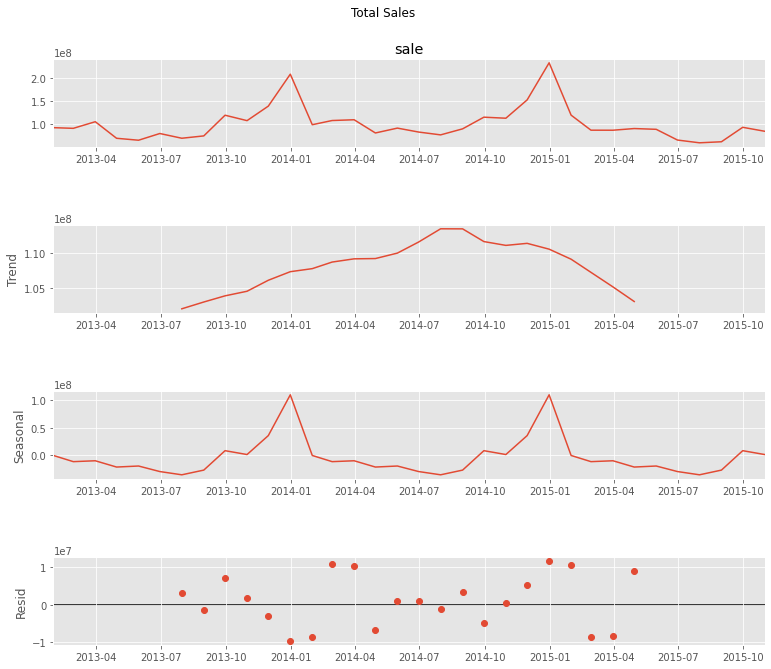

In [18]:
seasonal_decompose(df_monthly_sales.resample('M',on='date').sale.sum(), model='additive').plot()
plt.suptitle('Total Sales')
plt.tight_layout(pad=5)
plt.show()

The total sales have a seasonality, peak season Dec-Jan

In this table we can observe that the majority of the items a least started to being on sale 24 months before the latest date in our dataset

In [19]:
df_category_monthly_sales = df_monthly_sales.set_index("date")\
.groupby('product_type')\
.resample("M").sale.sum()\
.reset_index()\
.pivot_table(index='date',columns='product_type',values='sale',aggfunc='sum')



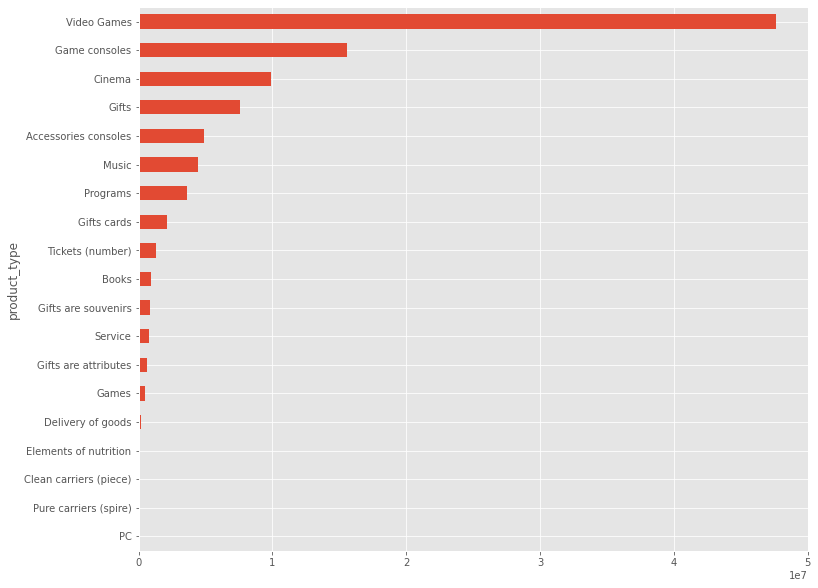

In [20]:
df_avg_sales_by_cat = df_category_monthly_sales.mean().sort_values(ascending=False)

df_avg_sales_by_cat.sort_values().plot.barh()
plt.show()

In [21]:
top_product_types = df_avg_sales_by_cat.head().index.tolist()

In [22]:
df_category_monthly_sales = df_category_monthly_sales.loc[:,top_product_types]

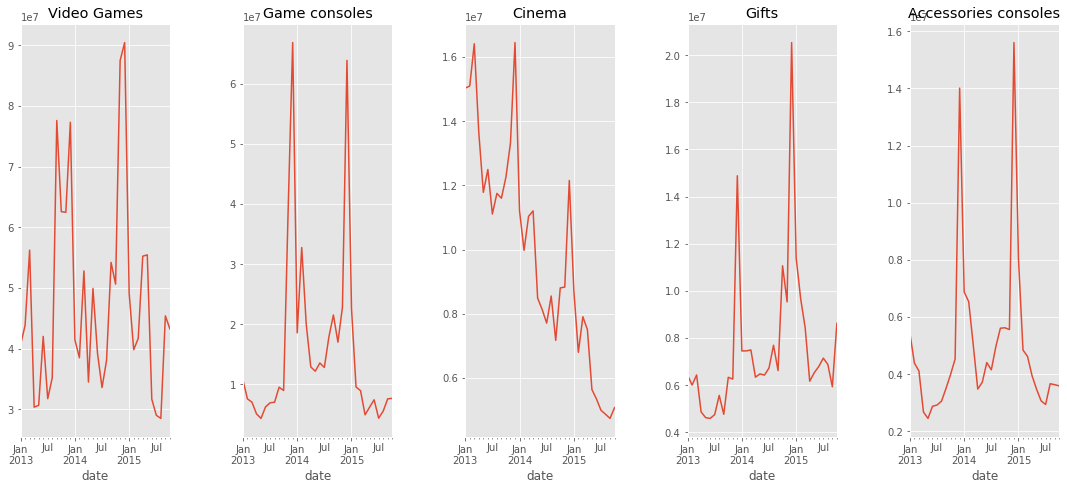

In [23]:

fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(16,8))
n = 0
for col in df_category_monthly_sales.columns:
  df_category_monthly_sales[col].plot(title=col,ax=axes[n])
  n +=1
plt.tight_layout(pad=5)
plt.show()




# Game Console

By looking the previous chart, we can observed that Game Consoles shows a strong seasonality (Peak season is from December to January), I can't notice a trend at first glance.

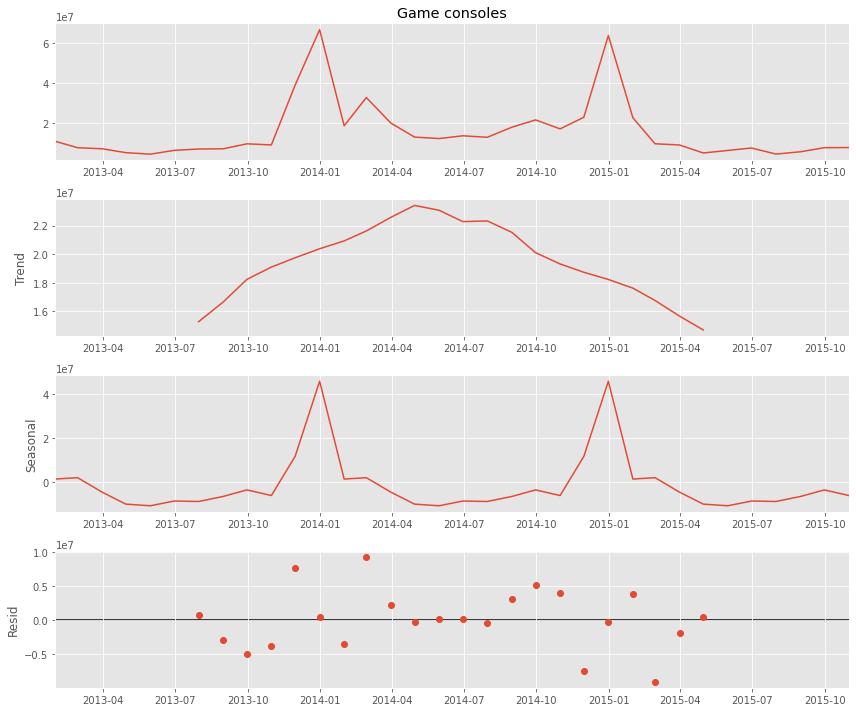

In [24]:
df_game_console = df_category_monthly_sales['Game consoles']
video_games = seasonal_decompose(df_category_monthly_sales['Game consoles'], model='additve')


video_games.plot()
plt.show()

# Is the game Console a stationary Serie?

In [25]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_game_console, autolag='AIC')
print('Observed')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

Observed
ADF Statistic: -3.4176594410639978
n_lags: 0
p-value: 0.010371393254222294
Critial Values:
   1%, -3.6461350877925254
Critial Values:
   5%, -2.954126991123355
Critial Values:
   10%, -2.6159676124885216


**For the obeseved values, we can see that a p-valueslower than 0.05 andt-statistic lower tha all the critical values. This time series is stationary**

In [26]:
result = adfuller(video_games.resid.dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   

ADF Statistic: 2.676108321549041
n_lags: 9
p-value: 0.9990853835989879
Critial Values:
   1%, -4.137829282407408
Critial Values:
   5%, -3.1549724074074077
Critial Values:
   10%, -2.7144769444444443


# Cinema

# Survival Analysis
 in this cases we going to use the date of the lastet recorded sale as the "day of his death"

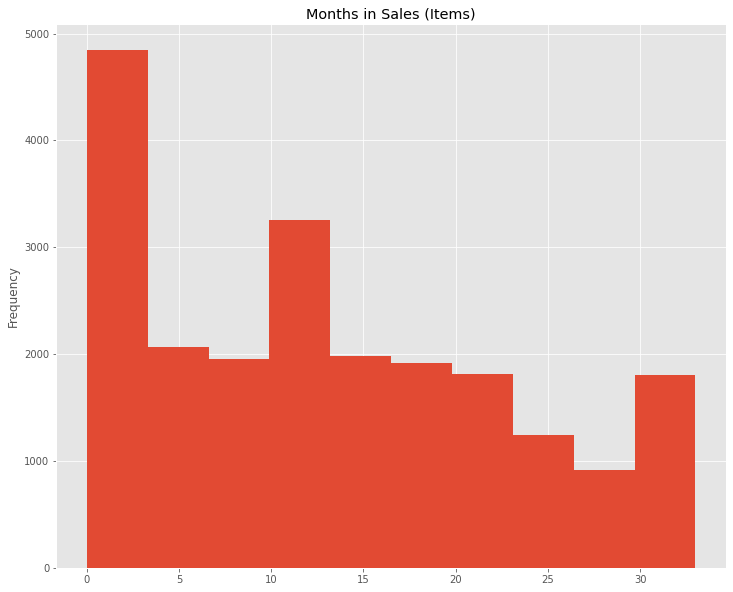

In [27]:
df_agg_monthly_sales = df_monthly_sales.reset_index().groupby(['item_id']).agg({'date':['min','max']})
df_agg_monthly_sales.columns = ['first_sale','last_sale']
df_agg_monthly_sales['months_in_sales'] = df_agg_monthly_sales.apply(lambda x: month_diff(x.first_sale,x.last_sale ), axis= 1)
df_agg_monthly_sales.months_in_sales.plot.hist(title='Months in Sales (Items)')
plt.show()

This graph shows the amount of items base on the months that they being on sale ( difference between first sale and last )

In [28]:

df_agg_monthly_sales['diff_last_date_and_first_sale'] = df_agg_monthly_sales.first_sale.apply(lambda x : month_diff(x,last_date))

df_agg_monthly_sales['diff_last_date_and_first_sale'].describe()

count    21804.000000
mean        24.284718
std         10.388885
min          0.000000
25%         17.000000
50%         29.000000
75%         33.000000
max         33.000000
Name: diff_last_date_and_first_sale, dtype: float64

In [29]:
filter_df_monthly_sales = df_monthly_sales\
.merge(df_agg_monthly_sales,on=['item_id'],how='left')\
.query('date>=first_sale & date<=last_sale ')\
.assign(months = lambda _x: _x.groupby('item_id').date.transform(lambda x: month_diff(x.min(),x.dt)),
        last_month_of_sales = lambda _x: _x.groupby('item_id').date.transform(lambda x: x.max()==x))\
.sort_values(['item_id','date'], ascending = False )\
.query("date < @last_date")

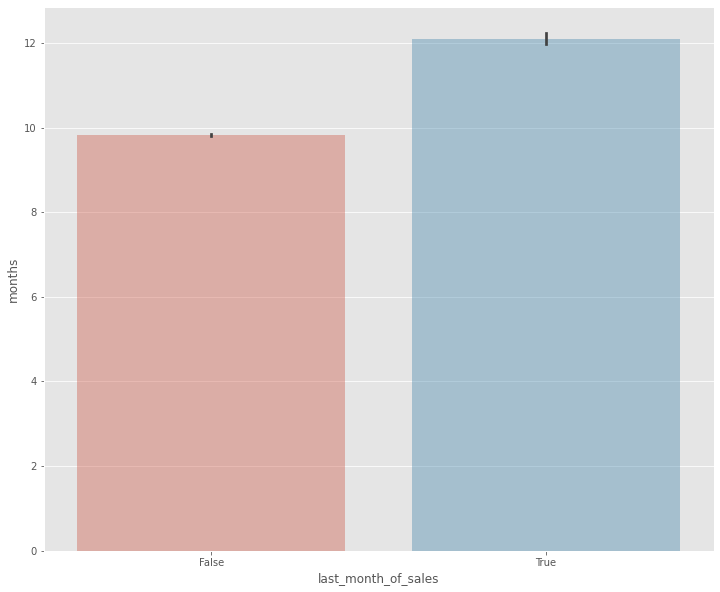

In [30]:
sns.barplot(data=filter_df_monthly_sales,x='last_month_of_sales',y="months", alpha=.4)
plt.show()

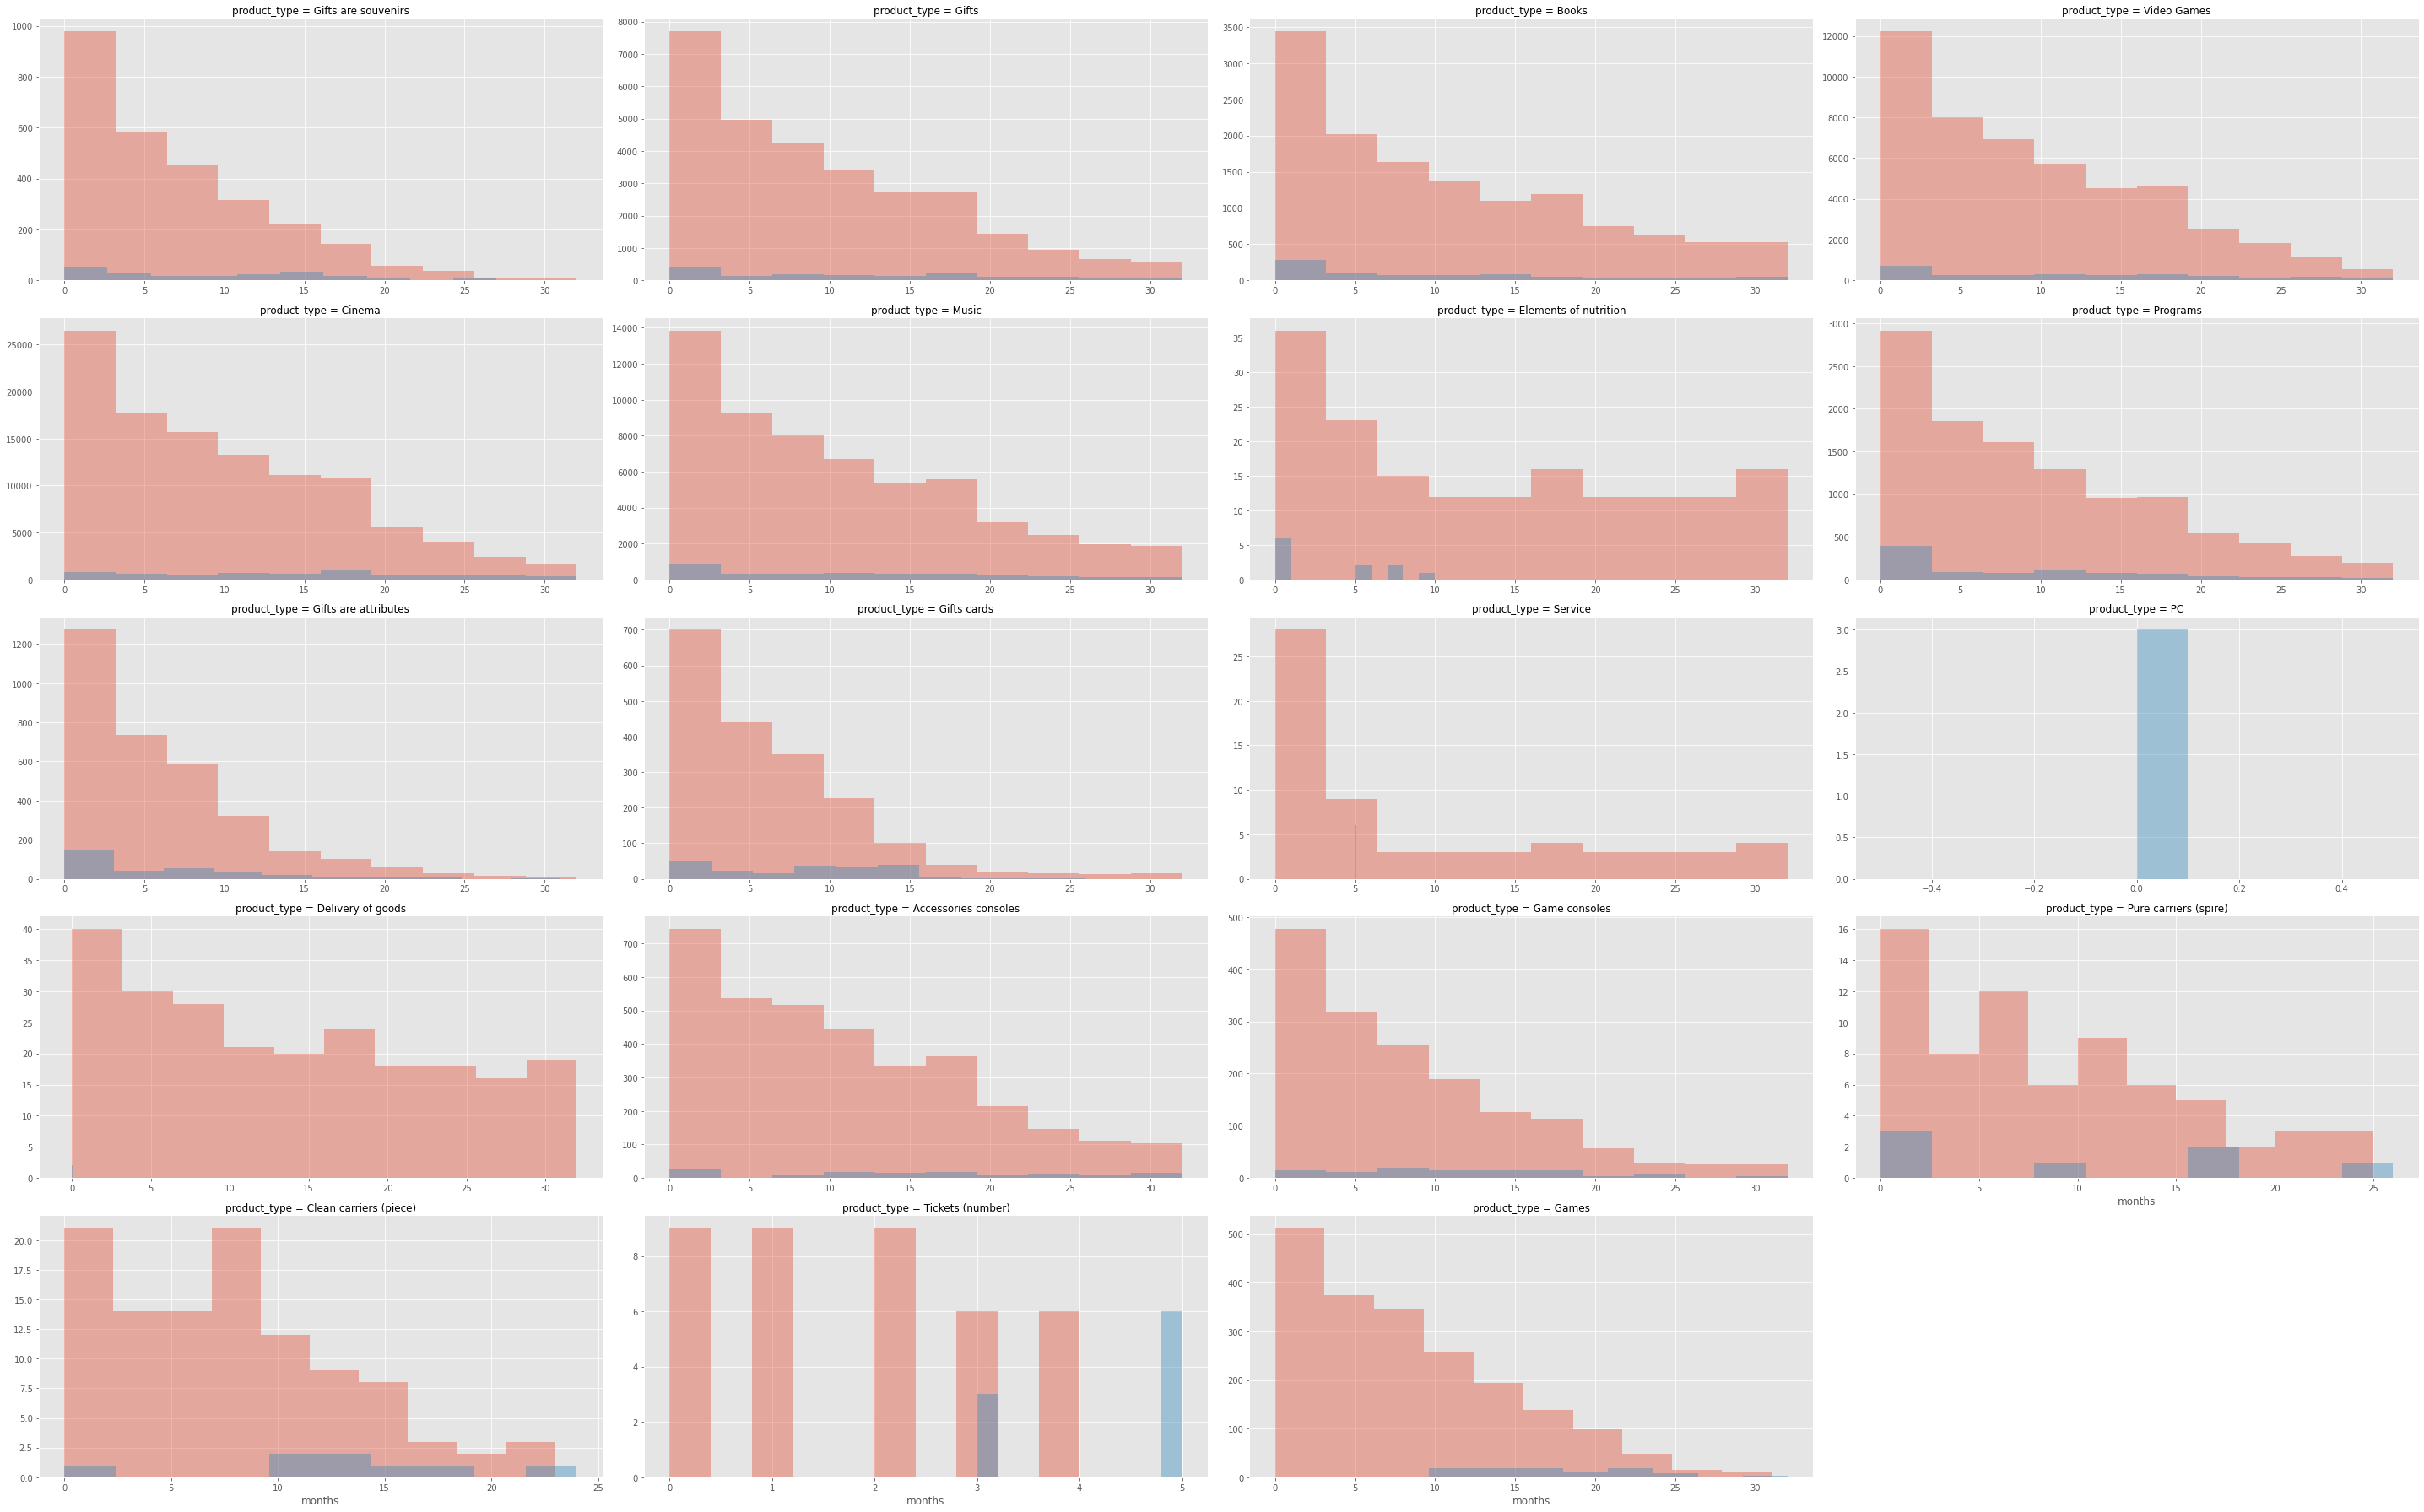

In [31]:
g = sns.FacetGrid(filter_df_monthly_sales,
                  hue="last_month_of_sales", 
                  col="product_type", 
                  col_wrap=4, 
                  sharex=False,
                  sharey=False,
                  aspect = 2, 
                  height= 5)
g.map(plt.hist, "months", alpha=.4)
plt.show()

Text(0, 0.5, 'Survival probability')

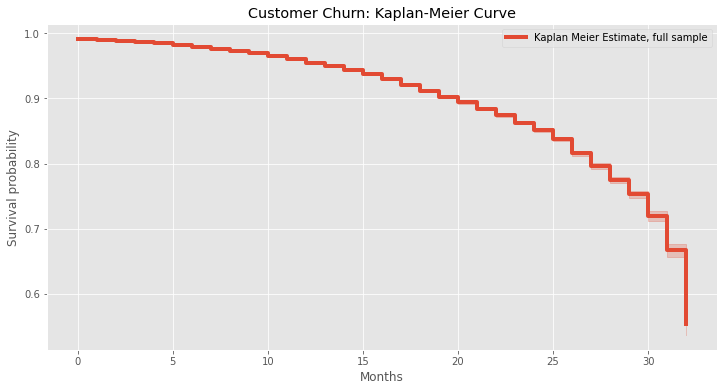

In [32]:
kmf = KaplanMeierFitter()

kmf.fit(filter_df_monthly_sales.months, filter_df_monthly_sales.last_month_of_sales, label = 'Kaplan Meier Estimate, full sample')

kmf.plot(linewidth=4, figsize=(12, 6))
plt.title('Customer Churn: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')

We observed big drop after the month 30, this is probably due the short time frame of sales in our dataset. In this section we conclude that we don't have enough data to make a survival analysis